<h1 align="center"> <b> Case study: Document Clustering for News Articles </b> </h1>

### Table of Contents
------
* Introduction
* Objective
* Preparation and data loading
* TF-IDF Word Tokenization
* k-means
* t-SNE
* Conclusion and final thoughts

### Introduction
------

In this case study, a collection of text documents should be clustered. Four CSV files are provided, all files contain only one column:

* *original_texts.csv*: News articles in their initial original form. Provided only for the sake of context.
* *preproc_texts.csv*: The preprocessed original texts from *original_texts.csv*: Only the first ten sentences from the original texts are displayed and punctuations are removed. This file should be used for clustering.
* *stopwords.csv*: The stop words from the preprocessed texts were already identified and put into this list.
* *labels.csv*: This list contains all corresponding correct labels (ground truth). This file should be used for reflecting the clustering only.

### Objective
------

Using the news article from *preproc_texts.csv*, a clustering method/model should developed and deployed. The clusters are unlabeled yet, since the labels from *labels.csv* are for verify purposes only. Hence, a unsupervised clustering model is to be applied to the news articles.

### Preparation and data loading
------

Unizpping the provided data as the first step:

In [1]:
# Unzip provided data
#!unzip "data/Case Study Data Scientist - Dataset.zip" -d data

Import libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE

Load CSV files intro pandas DataFrames. In the case of *original_texts.csv* the delimiter is set to the tabulator character, instead of the comma as the default delimiter character.

In [3]:
# Load the data and store them into pandas DataFrames
stop = pd.read_csv("data/stopwords.csv", header=None)
pre = pd.read_csv("data/preproc_texts.csv", header=None)
org = pd.read_csv("data/original_texts.csv", header=None, delimiter="\t")
labels = pd.read_csv("data/labels.csv", header=None)

There are 37 news articles. Article number 13 and number 15 don't contain proper news articles. Number 13 is an error message *"Why did this happen Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading For more information you can review our Terms of Service and Cookie Policy"* and number 15 is a browser search message: *"What term do you want to search Search with google"*. These messages also appear in the original dataset *original_texts.csv*. Since they are labeled with *pollution_national_parks* and *uk_inflation_data*, respectively, a correct clustering for these two observations are impossible. 
The method how to deal with that is described below at the model implementation of k-means.

As mentioned above, all four CSV file consist of only one column filled with strings. The DataFrames are converted to lists:

In [4]:
# Convert DataFrames to lists
corpus = list(pre[0])
stop_words_list = list(stop[0])
labels_list = list(labels[0])

### TF-IDF Word Tokenization
------

[Term Frequency - Inverse Document Frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) word vectorization of all words in every news article. TF-IDF is used, because some words appear more often in the context of specific topics. For example the word "climate" is more frequently used in articles about climate change rather than in sports news. TF-IDF ensures that the vectors are higher with increasing term frequency, but also decreased by the frequency of cross-article occurences.

The obtained vectors are used as features. Before that, the process of [stemming](https://en.wikipedia.org/wiki/Stemming) is implemented to aggregate all the words with the same word stem. Additionally, the stop words from the stop words list are removed.

In [5]:
# Initialize stemmer (without stop words)
stemmer = nltk.PorterStemmer()
analyzer = TfidfVectorizer(stop_words=stop_words_list).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [6]:
# TF-IDF
vectorizer = TfidfVectorizer(analyzer=stemmed_words)
X = vectorizer.fit_transform(corpus)

# Check the shape
print(X.shape)

(37, 1482)


After the the stemming, removial of stopwords and TF-IDF vectorization, the shape of the vectorized data is 37 x 1482, which means 37 observations (articles) and 1482 features (vectorized words). 

### k-means
------

The clustering algorithm [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) starts with random positions of *k* centers of clusters (centroids). Then, all observations were assigned to the nearest cluster. Ater that step, the mean observation position within one cluster is recalculated and the centroid moves to this very position. The process of assigning observations to nearest centroids starts over again. k-means is often used for clustering. The algorithm is quite simple and the identicifation of complex cluster patterns seems not required for this task. However, the number of clusters *k* should be declared beforehand. To find the best *k*, the elbow method can be used. The elbow method allows to visualize the within-cluster sum of squared estimate of errors (SSE) against *k*. The code of the elbow method and visualization is borrowed from [kaggle](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans/notebook) and modified/extended.

In [7]:
# The calculation and visualization of all SSE values using k-means with different k values
def find_optimal_clusters(data, max_k, fit_points=None, fit_extend=None):
    iters = range(2, max_k+1)

# Append the results into the dictionary "sse"
    sse = []
    for k in iters:
        global model
        model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        model.fit(data)
        sse.append(model.inertia_)
        if k == max_k:
            print('Fit {} clusters'.format(k))

# Plot the results
    f, ax = plt.subplots(1, 1)
    f.set_figwidth(15)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
# Plot linear fit for first nine points
    if fit_points!=None and fit_extend!=None: 
        m, b = np.polyfit(iters[:fit_points], sse[:fit_points], 1)
        plt.plot(iters[:fit_extend], m*iters[:fit_extend] + b)
        print("First " + str(len(iters[:fit_points])) + " points linear fitted")
# Save figure
    f.savefig('data/Elbow_fit_{}.png'.format(fit_points), dpi=300, bbox_inches='tight') 

Fit 37 clusters


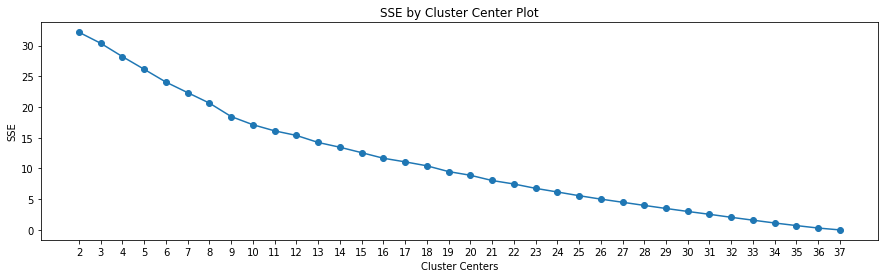

In [8]:
# Applied on our data    
find_optimal_clusters(X, 37)

Although in the SSE plot above a clear "elbow" is missing, a trend is discernible that divides the graph in two separate linear patterns. A linear fit is therefore manually added to k <= 9:  

Fit 37 clusters
First 9 points linear fitted


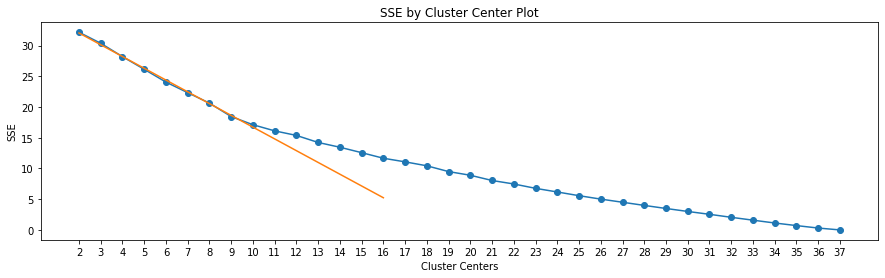

In [9]:
find_optimal_clusters(X, 37, 9, 15)

Therefore, k = 9 clusters are firstly chosen for the k-means model. k = 10 also seems to be a reasonable choice, which will be chosen afterwards.

In [10]:
# k-means with k = 9
clusters = KMeans(n_clusters = 9, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit_predict(X)

What are the top keywords in each cluster? To determine the top three words, the following function was borrowed from [kaggle](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans/notebook).

In [11]:
# Function to determine top keywords
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    global cluster_top_dict
    cluster_top_dict = {}
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        top = ', '.join([labels[t] for t in np.argsort(r)[:-(n_terms+1):-1]])
        cluster_top_dict[i] = top
        print(top)

The top three (stemmed) keywords:

In [12]:
get_top_keywords(X, clusters, vectorizer.get_feature_names_out(), 3)


Cluster 0
climat, today, threat

Cluster 1
bed, space, studi

Cluster 2
food, guid, canada

Cluster 3
linux, kernel, window

Cluster 4
ozon, park, air

Cluster 5
cillian, team, robot

Cluster 6
price, inflat, rise

Cluster 7
search, cathedr, pari

Cluster 8
meteor, satellit, shower


Now we have got a result. But how successful performed the model compated to the provided ground truth labels in *labels.csv*? The homogeneity score serves as a metric:

In [13]:
# Homogeneity score
homogeneity_score(labels_list, list(clusters))

0.9383705592691584

The homogeneity score of ~0.94 is high, but not perfect. After verifying the results, news article 13 and 15 were not correctly assigned, because they contain error messages. So a 10th cluster is now used:

In [14]:
# k-means with k = 10
clusters = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit_predict(X)

Check the top three keywords again:

In [15]:
get_top_keywords(X, clusters, vectorizer.get_feature_names_out(), 3)


Cluster 0
cillian, team, robot

Cluster 1
ozon, park, air

Cluster 2
food, guid, canada

Cluster 3
bed, space, studi

Cluster 4
price, inflat, rise

Cluster 5
linux, kernel, window

Cluster 6
meteor, satellit, shower

Cluster 7
cathedr, pari, franc

Cluster 8
climat, today, threat

Cluster 9
search, cooki, term


To get a better overview of all the clusters:

In [16]:
for i,j in enumerate(clusters):
    print("News article " + str(i+1) + " assigned to cluster: " + cluster_top_dict[j])

News article 1 assigned to cluster: food, guid, canada
News article 2 assigned to cluster: linux, kernel, window
News article 3 assigned to cluster: cillian, team, robot
News article 4 assigned to cluster: cillian, team, robot
News article 5 assigned to cluster: meteor, satellit, shower
News article 6 assigned to cluster: bed, space, studi
News article 7 assigned to cluster: food, guid, canada
News article 8 assigned to cluster: cathedr, pari, franc
News article 9 assigned to cluster: ozon, park, air
News article 10 assigned to cluster: ozon, park, air
News article 11 assigned to cluster: climat, today, threat
News article 12 assigned to cluster: climat, today, threat
News article 13 assigned to cluster: search, cooki, term
News article 14 assigned to cluster: meteor, satellit, shower
News article 15 assigned to cluster: search, cooki, term
News article 16 assigned to cluster: food, guid, canada
News article 17 assigned to cluster: cillian, team, robot
News article 18 assigned to clust

Now, news article 13 and 15 are correctly assigned to the new cluster with the top three keywords *"search, cooki, term"*. Eventhough it is not the ground truth, it makes sense to cluster them in an extra cluster to show their erroneous contents.

### t-SNE
------

How does it look like? To visualize it, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is used to plot the clusters in two dimensions:

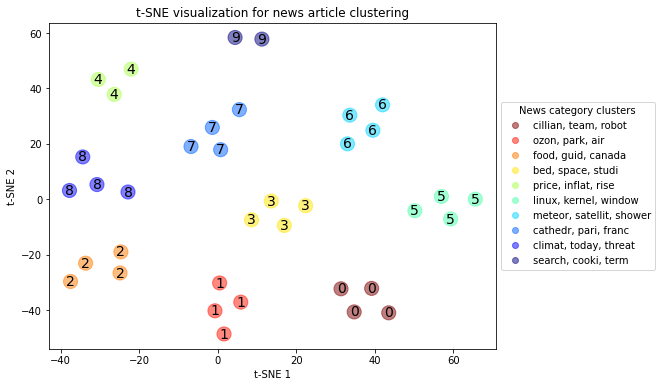

In [17]:
# t-SNE with perplexity=10
model = TSNE(n_components=2, random_state=0, perplexity=10, learning_rate="auto", init="random")
np.set_printoptions(suppress=True)
Y = model.fit_transform(X)
 
# Plot the results of clustering
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(Y[:,0], Y[:,1], c=clusters, cmap="jet_r", s=200, alpha=.5)
ax.legend(handles=scatter.legend_elements()[0], labels=list(cluster_top_dict.values()), title='News category clusters', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

for j in range(len(clusters)):    
    plt.annotate(clusters[j], xy=(Y[j][0], Y[j][1]), xytext=(0,0), textcoords='offset points', fontsize=14, ha='center', va='center')
plt.title("t-SNE visualization for news article clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show();

# Save figure
fig.savefig('data/t-sne.png', dpi=300, bbox_inches='tight')

### Conclusion and final thoughts
------

The approach using TF-IDF vectorization and k-means could successfully cluster all news articles correctly. The content of two news articles were not properly copied into the initial original file and were clustered into a new own cluster. The breaking point of this approach is the rather ambiguous elbow to determine the number of clusters *k*. To enhance this method, I would love to get feedback and some tips to improve the model.
For future works, more news articles can be loaded into the document corpus in order to test the model with larger datasets.